<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 12
27 January 2022

## Problem 10.1 - Recursive Filter
For $n = 100 000$, consider a BPSK sample sequence
$x^n$ where the entries $x_i$ are sampled independent and uniformly distributed on $\{-1, 1\}$.
The sequence is filtered and the filter output yn is observed, where
$$y_i = x_i + \alpha x_{i-1}, \hspace{1cm} i = 0, 1, \dots , n-1$$
with $\alpha = 0.5$ For initialization, we assume $x_{-1} = x_{n-1}$. Our goal is to recover $x^n$ from $y^n$
* 1. Plot the PSD of $x^n$ and $y^n$.
* 2. Show that the recursive filter $f(y_i) = y_i + \alpha f(x_{i-1})$ recovers $x^n$.

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

In [2]:
n = 100000
alpha = 0.5
x = np.random.choice([-1.,1.], n)
y = x + alpha * np.roll(x, 1)

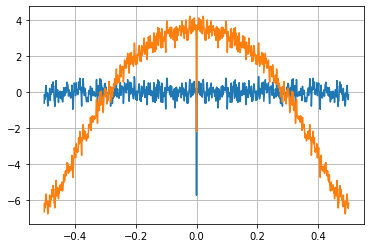

In [3]:
f, Pxx = signal.welch(x, return_onesided=False, nperseg=1000)
f, Pyy = signal.welch(y, return_onesided=False, nperseg=1000)
plt.plot(np.fft.fftshift(f),10*np.log10(np.fft.fftshift(Pxx)))
plt.plot(np.fft.fftshift(f),10*np.log10(np.fft.fftshift(Pyy)))
plt.grid()
plt.show()

* 3. Implement the recursive filter. How does the residual error $f(y_i)- x_i$  look like when you initialize with $f(y_{i-1}) = 0$ and $f(y_{i-1}) = x_{i-1}$ .

In [4]:
def recursive_filter(x, alpha, h0=0):
    y = np.zeros(x.shape)
    y[-1] = h0
    for i in range(len(y)):
        y[i] = x[i] + alpha * y[i - 1]
    return y

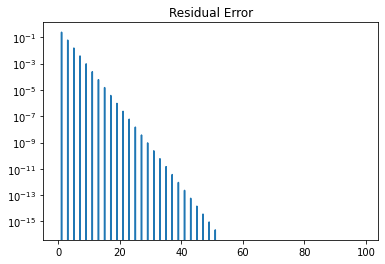

In [5]:
x_hat = recursive_filter(y, -alpha)
residual_error = x_hat - x
plt.semilogy(residual_error[:100])
plt.title('Residual Error')
plt.show()

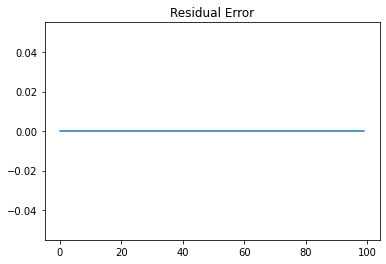

In [6]:
x_hat = recursive_filter(y, -alpha, h0=x[-1])
residual_error = x_hat - x
plt.plot(residual_error[:100])
plt.title('Residual Error')
plt.show()

* 4. Implement the recursive filter in an NN by using one linear layer with 2 inputs and one output. Train the NN and evaluate the residual error for initializing with $f(y_{i-1}) = 0$ and $f(y_{i-1}) = x_{i-1}$ .

In [7]:
class RecursiveFilter(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 1)
        )

    def forward(self, x, h0):
        x = x.reshape(-1, 1)
        y = torch.zeros(x.shape)
        y[0] = self.model(torch.cat([x[0], h0]))
        for i in range(1, len(x)):
            y[i] = self.model(torch.cat([x[i], y[i - 1]]))
        return y

In [8]:
def sample(n, alpha):
    x = np.random.choice([-1.,1.], n)
    y = x + alpha * np.roll(x, 1)
    return torch.Tensor(x).reshape(-1, 1), torch.Tensor(y).reshape(-1, 1)

def pt2np(x):
    return x.detach().reshape(-1).numpy()

In [9]:
# Here we initialize f(y_i-1) = 0
n_epochs = 201
batch_size = 1000
alpha = 0.5
rnn = RecursiveFilter()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr=1e-2)

for j in range(n_epochs):
    x, y = sample(batch_size, alpha)
    # h0 = x[-1] 
    h0 = torch.Tensor([0.])
    x_hat = rnn(y, h0)
    loss = loss_fn(x, x_hat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if j > 0 and j % 10 == 0:
        print(f'Epoch {j}: loss = {loss :.4f}')
residual_error_0 = pt2np(x - x_hat)

Epoch 10: loss = 0.1885
Epoch 20: loss = 0.0873
Epoch 30: loss = 0.0340
Epoch 40: loss = 0.0099
Epoch 50: loss = 0.0044
Epoch 60: loss = 0.0024
Epoch 70: loss = 0.0011
Epoch 80: loss = 0.0006
Epoch 90: loss = 0.0004
Epoch 100: loss = 0.0003
Epoch 110: loss = 0.0003
Epoch 120: loss = 0.0003
Epoch 130: loss = 0.0003
Epoch 140: loss = 0.0003
Epoch 150: loss = 0.0003
Epoch 160: loss = 0.0003
Epoch 170: loss = 0.0003
Epoch 180: loss = 0.0003
Epoch 190: loss = 0.0003
Epoch 200: loss = 0.0003


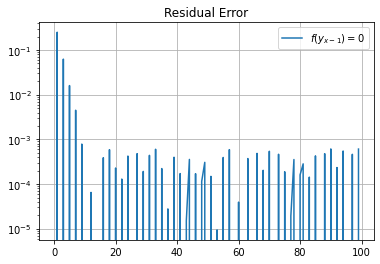

In [10]:
# Plot of the residual error
residual_error = pt2np(x - x_hat)
plt.semilogy(residual_error_0[:100], label='$f(y_{x-1})=0$')
plt.legend()
plt.title('Residual Error')
plt.grid()

In [11]:
# Here we initialize f(y_i-1) = x_i-1
n_epochs = 201
batch_size = 1000
alpha = 0.5
rnn = RecursiveFilter()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr=1e-2)

for j in range(n_epochs):
    x, y = sample(batch_size, alpha)
    h0 = x[-1] 
    # h0 = torch.Tensor([0.])
    x_hat = rnn(y, h0)
    loss = loss_fn(x, x_hat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if j > 0 and j % 10 == 0:
        print(f'Epoch {j}: loss = {loss :.4f}')

Epoch 10: loss = 0.3141
Epoch 20: loss = 0.1892
Epoch 30: loss = 0.1078
Epoch 40: loss = 0.0538
Epoch 50: loss = 0.0256
Epoch 60: loss = 0.0111
Epoch 70: loss = 0.0039
Epoch 80: loss = 0.0012
Epoch 90: loss = 0.0003
Epoch 100: loss = 0.0000
Epoch 110: loss = 0.0000
Epoch 120: loss = 0.0000
Epoch 130: loss = 0.0000
Epoch 140: loss = 0.0000
Epoch 150: loss = 0.0000
Epoch 160: loss = 0.0000
Epoch 170: loss = 0.0000
Epoch 180: loss = 0.0000
Epoch 190: loss = 0.0000
Epoch 200: loss = 0.0000


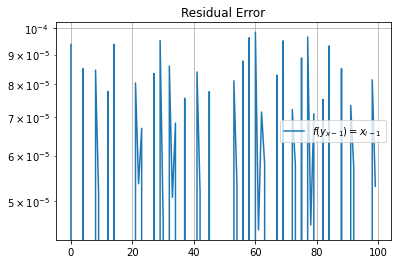

In [12]:
# Plot of the residual error
residual_error = pt2np(x - x_hat)
plt.semilogy(residual_error[:100], label='$f(y_{x-1})=x_{i-1}$')
plt.legend()
plt.title('Residual Error')
plt.grid()

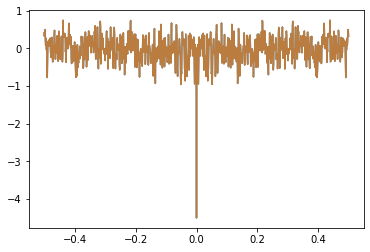

In [14]:
# Check the reconstructed signal
x, y = sample(100_000, alpha)
h0 = x[-1] # providing the initial state improves the loss
# h0 = torch.Tensor([0.])
x_hat = rnn(y, h0)

f, Pxx = signal.welch(pt2np(x), return_onesided=False, nperseg=1000)
f, Pyy = signal.welch(pt2np(x_hat), return_onesided=False, nperseg=1000)


### Using Pytorch RNN
* 5. Implement the recursive filter by using torch.nn.RNN with:

input_size = 1 

hidden_size = 1

num_layers = 1

nonlinearity = 'tanh'

Train the NN and evaluate the residual error for initializing with $f(y_{i-1}) = 0$ and $f(y_{i-1}) = x_{i-1}$ .


From the pytorch documentation:
#### Parameters
* input_size – The number of expected features in the input x
* hidden_size – The number of features in the hidden state h
* num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1
* nonlinearity - The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'.

#### Input/Output Format

* Inputs: x, h0 with x.shape = (L, N, Hin) and h0.shape = (D * num_layers, N, Hout)
* Outputs: y, hn with y.shape = (L, N, D* Hout) and hn.shape = (D∗num_layers,N,Hout)
* where
  * N = batch_size
  * L = sequence_length
  * D = 1 or 2 (bidirectional)
  * Hin = input_size
  * Hout = hidden_size

In [17]:
class RecursiveFilterRNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.RNN(input_size=1,
                            hidden_size=1,
                            num_layers=1,
                            nonlinearity='tanh')
        
    def forward(self, x, h0):
        '''
        Parameters
        ----------
        x : array of shape (sequence_length, batch_size, input_size)
        
        h0 : array of shape (D*num_layers, batch_size, hidden_size)
        '''
        out, hn = self.model(x, h0)
        return out

In [18]:
# Here we initialize f(y_i-1) = 0
n_epochs = 1001
batch_size = 1
sequence_length = 1000
alpha = 0.5
rnn_t = RecursiveFilterRNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(rnn_t.parameters(), lr=1e-2)

for j in range(n_epochs):
    x, y = sample(sequence_length, alpha)
    #h0 = x[-1] 
    h0 = torch.Tensor([0.])
    x_hat = rnn_t(y.reshape(sequence_length, batch_size, 1), h0.reshape(1, batch_size, 1)).reshape(-1, 1)
    loss = loss_fn(x, x_hat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if j > 0 and j % 100 == 0:
        print(f'Epoch {j}: loss = {loss :.4f}')
residual_error_0 = pt2np(x - x_hat)        

Epoch 100: loss = 0.2192
Epoch 200: loss = 0.0554
Epoch 300: loss = 0.0271
Epoch 400: loss = 0.0166
Epoch 500: loss = 0.0113
Epoch 600: loss = 0.0084
Epoch 700: loss = 0.0065
Epoch 800: loss = 0.0052
Epoch 900: loss = 0.0041
Epoch 1000: loss = 0.0035


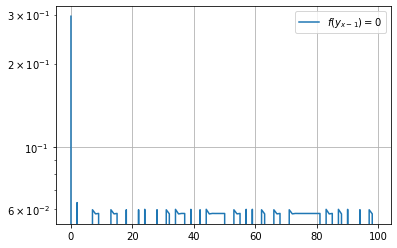

In [19]:
# Plot of the residual error
residual_error = pt2np(x - x_hat)
plt.semilogy(residual_error_0[:100], label='$f(y_{x-1})=0$')
plt.legend()
plt.grid()

In [20]:
# Here we initialize f(y_i-1) = x_i-1
n_epochs = 1001
batch_size = 1
sequence_length = 1000
alpha = 0.5
rnn_t = RecursiveFilterRNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(rnn_t.parameters(), lr=1e-2)

for j in range(n_epochs):
    x, y = sample(sequence_length, alpha)
    h0 = x[-1] 
    # h0 = torch.Tensor([0.])
    x_hat = rnn_t(y.reshape(sequence_length, batch_size, 1), h0.reshape(1, batch_size, 1)).reshape(-1, 1)
    loss = loss_fn(x, x_hat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if j > 0 and j % 100 == 0:
        print(f'Epoch {j}: loss = {loss :.4f}')

Epoch 100: loss = 1.9948
Epoch 200: loss = 0.2785
Epoch 300: loss = 0.0422
Epoch 400: loss = 0.0206
Epoch 500: loss = 0.0128
Epoch 600: loss = 0.0089
Epoch 700: loss = 0.0067
Epoch 800: loss = 0.0052
Epoch 900: loss = 0.0042
Epoch 1000: loss = 0.0034


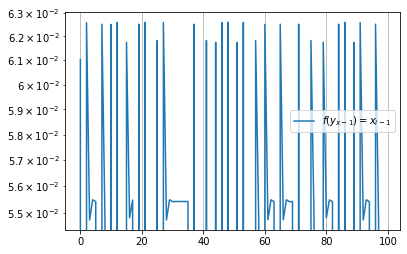

In [21]:
# Plot of the residual error
residual_error = pt2np(x - x_hat)
plt.semilogy(residual_error[:100], label='$f(y_{x-1})=x_{i-1}$')
plt.legend()
plt.grid()

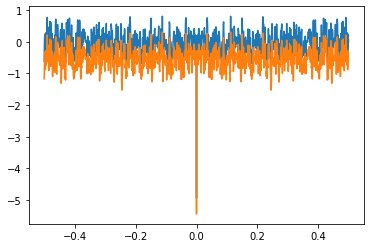

In [22]:
x, y = sample(100_000, alpha)
h0 = x[-1] # providing the initial state improves the loss
# h0 = torch.Tensor([0.])
x_hat = rnn_t(y.reshape(100_000, batch_size, 1), h0.reshape(1, batch_size, 1)).reshape(-1, 1)

f, Pxx = signal.welch(pt2np(x), return_onesided=False, nperseg=1000)
f, Pyy = signal.welch(pt2np(x_hat), return_onesided=False, nperseg=1000)
plt.plot(np.fft.fftshift(f),10*np.log10(np.fft.fftshift(Pxx)))
plt.plot(np.fft.fftshift(f),10*np.log10(np.fft.fftshift(Pyy)))
plt.show()

## Problem 10.2 - Colored Noise 
Consider a sampled BPSK sequence $x^n$. A channel
adds colored noise, i.e.,
$$y_i = x_i + z_i ,\hspace{1cm}  i  =  0, \dots, : : : ; n-1 $$
$$z_i = \tilde{z}_i + \alpha \tilde{z}_{i-1} $$
$$\tilde{z}_{-1} = \tilde{z}_{n-1}$$
where the $\tilde{z_i}$ are independent zero mean Gaussians with variance $\sigma^2$. Our goal is to soft
demap the bit $b = \phi{x}$, where $\phi(-1)=0$ and $\phi(1)=1$.
* 1. What is the variance of $Z_i$? What is the optimal memoryless demapper? (the
memoryless demapper assumes that the $Z_i$ are independent zero mean Gaussian).
Plot the BER against $1/\sigma^2$ in dB over a range of values.

In [23]:
n = 1000000
alpha = 0.9
sigma2 = 1
x = np.random.choice([-1.,1.], n)
b = np.zeros(n)
b[x>0]= 1
z_tilde = np.sqrt(sigma2) * np.random.randn(n)
z = z_tilde + alpha * np.roll(z_tilde, 1)
y = x + z

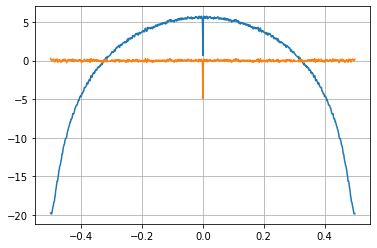

In [24]:
f, Pz = signal.welch(z, return_onesided=False, nperseg=1000)
f, Pzt = signal.welch(z_tilde, return_onesided=False, nperseg=1000)
plt.plot(np.fft.fftshift(f),10*np.log10(np.fft.fftshift(Pz)))
plt.plot(np.fft.fftshift(f),10*np.log10(np.fft.fftshift(Pzt)))
plt.grid()
plt.show()

In [25]:
# Optimal memoryless demapper
sigma2_range = np.array([0.05, 0.1, 0.3, 0.5, 1])
bers_memoryless = []
for sigma2 in sigma2_range:
    z_tilde = np.sqrt(sigma2) * np.random.randn(n)
    z = z_tilde + alpha * np.roll(z_tilde, 1)
    y = x + z
    b_hat = np.zeros(n)
    b_hat[y>0] = 1
    bers_memoryless.append(sum(b != b_hat)/n)

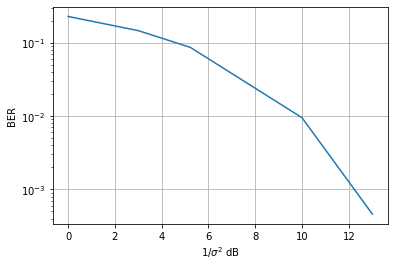

In [26]:
# plot
plt.semilogy(10*np.log10(1/sigma2_range), bers_memoryless)
plt.grid()
plt.ylabel('BER')
plt.xlabel('1/$\sigma^2$ dB')
plt.show()

#### Use linear NNs
* 2. Implement a linear NN demapper with m filter taps. Train the demapper and plot
the BER curve.

In [27]:
def sample_colored_noise(n, sigma2):
    x = np.random.choice([-1.,1.], n)
    b = np.zeros(n)
    b[x>0]= 1
    b_t = torch.tensor(b)
        
    z_tilde = np.sqrt(sigma2) * np.random.randn(n)
    z = z_tilde + alpha * np.roll(z_tilde, 1)
    y = x + z
    y_t = torch.tensor(y)
    
    return b_t, torch.tensor(x), y_t

In [28]:
def getchunks(x, num_taps=21):
    x = x.reshape(-1, 1)
    chunks = torch.zeros(x.shape[0], num_taps)
    for j in range(num_taps):
        chunks[:, j:j+1] = torch.roll(x, j - num_taps//2)
    return chunks

In [29]:
class MemoryDemapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(21, 1)
        )

    def forward(self, y):
        return self.model(y)

In [30]:
n = 1_000_000
n_epochs = 1001
batch_size = 1000
alpha = 0.9
demap = MemoryDemapper()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(demap.parameters(), lr=1e-2)

bers_linearNN = []
for sigma2 in sigma2_range:
    print(f'--- sigma2 is {sigma2}')
    for j in range(n_epochs):    
        b_t, x_t, y_t = sample_colored_noise(batch_size, sigma2)
        l = demap(getchunks(y_t)).reshape(-1)
        loss = loss_fn(l, b_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if j > 0 and j % 100 == 0:
            print(f'Epoch {j}: loss = {loss/np.log(2) :.4f} bits')
            
    b_t, x_t, y_t = sample_colored_noise(n, sigma2)

    b_hat = np.zeros(n)
    l = demap(getchunks(y_t)).reshape(-1)
    b_hat[l>0] = 1
    bers_linearNN.append(sum(b_hat!=b_t.detach().numpy())/n)
    print(f'BER is {sum(b_hat!=b_t.detach().numpy())/n}')


--- sigma2 is 0.05
Epoch 100: loss = 0.5179 bits
Epoch 200: loss = 0.3029 bits
Epoch 300: loss = 0.2019 bits
Epoch 400: loss = 0.1477 bits
Epoch 500: loss = 0.1181 bits
Epoch 600: loss = 0.0975 bits
Epoch 700: loss = 0.0802 bits
Epoch 800: loss = 0.0659 bits
Epoch 900: loss = 0.0586 bits
Epoch 1000: loss = 0.0505 bits
BER is 0.000333
--- sigma2 is 0.1
Epoch 100: loss = 0.0758 bits
Epoch 200: loss = 0.0653 bits
Epoch 300: loss = 0.0673 bits
Epoch 400: loss = 0.0731 bits
Epoch 500: loss = 0.0680 bits
Epoch 600: loss = 0.0576 bits
Epoch 700: loss = 0.0542 bits
Epoch 800: loss = 0.0509 bits
Epoch 900: loss = 0.0549 bits
Epoch 1000: loss = 0.0371 bits
BER is 0.007225
--- sigma2 is 0.3
Epoch 100: loss = 0.2549 bits
Epoch 200: loss = 0.2872 bits
Epoch 300: loss = 0.2265 bits
Epoch 400: loss = 0.2278 bits
Epoch 500: loss = 0.2701 bits
Epoch 600: loss = 0.2152 bits
Epoch 700: loss = 0.2174 bits
Epoch 800: loss = 0.2490 bits
Epoch 900: loss = 0.2154 bits
Epoch 1000: loss = 0.2596 bits
BER is 0.0

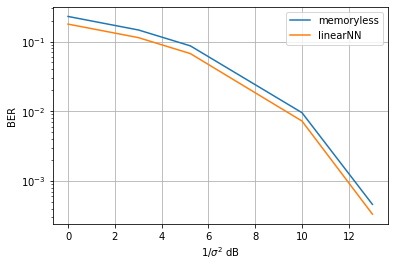

In [31]:
# plot
plt.semilogy(10*np.log10(1/sigma2_range), bers_memoryless, label='memoryless')
plt.semilogy(10*np.log10(1/sigma2_range), bers_linearNN, label='linearNN')
plt.grid()
plt.ylabel('BER')
plt.xlabel('1/$\sigma^2$ dB')
plt.legend()
plt.show()

#### Use RNNs
* 3. Implement a recursive NN demapper using torch.nn.RNN with input size=1.
Try out several values for hidden size and num layers and try out both
nonlinearity = ’tanh’ and nonlinearity = ’relu’. In all cases, terminate
the NN with a linear layer. Train the demapper and plot the BER curve.

In [33]:
class RecursiveDemapper(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.RNN(input_size=1,
                            hidden_size=4,
                            num_layers=2,
                            nonlinearity='relu',
                            bidirectional=True)
        self.out = nn.Linear(8, 1)
        
    def forward(self, x, h0):
        y, hn = self.model(x, h0)
        return self.out(y)

In [ ]:
n_epochs = 401
batch_size = 1
sequence_length = 1000
alpha = 0.9
rnn_t = RecursiveDemapper()
optimizer = optim.Adam(rnn_t.parameters(), lr=1e-2)
bers_RNN = []
for sigma2 in sigma2_range:
    print(f'--- sigma2 is {sigma2}')
    for j in range(n_epochs):
        b_t, x_t, y_t = sample_colored_noise(sequence_length, sigma2)
        h0 = torch.tensor([x_t[-1]] * 16)
        l = rnn_t(y_t.reshape(sequence_length, batch_size, 1).float(), h0.reshape(4, 1, 4).float()).reshape(-1)
        loss = loss_fn(l, b_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if j > 0 and j % 100 == 0:
            print(f'Epoch {j}: loss = {loss/np.log(2) :.4f} bits')
       
    
    b_t, x_t, y_t = sample_colored_noise(n, sigma2)
    h0 = torch.tensor([x_t[-1]] * 16)

    b_hat = np.zeros(n)
    l = rnn_t(y_t.reshape(n, batch_size, 1).float(), h0.reshape(4, 1, 4).float()).reshape(-1)
    b_hat[l>0] = 1
    bers_RNN.append(sum(b_hat!=b_t.detach().numpy())/n)
    print(f'BER is {sum(b_hat!=b_t.detach().numpy())/n}')
        

--- sigma2 is 0.05
Epoch 100: loss = 0.0043 bits
Epoch 200: loss = 0.0030 bits
Epoch 300: loss = 0.0036 bits
Epoch 400: loss = 0.0010 bits
BER is 0.000308
--- sigma2 is 0.1
Epoch 100: loss = 0.0270 bits
Epoch 200: loss = 0.0118 bits
Epoch 300: loss = 0.0090 bits
Epoch 400: loss = 0.0181 bits


In [ ]:
# plot
plt.semilogy(10*np.log10(1/sigma2_range), bers_memoryless, label='memoryless')
plt.semilogy(10*np.log10(1/sigma2_range), bers_linearNN, label='linearNN')
plt.semilogy(10*np.log10(1/sigma2_range), bers_RNN, label='RNN')
plt.grid()
plt.ylabel('BER')
plt.xlabel('1/$\sigma^2$ dB')
plt.legend()
plt.show()